In [17]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import joblib

from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score, \
                            auc, confusion_matrix, accuracy_score, \
                            classification_report

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
df_data_general = pd.read_csv('../../../data/data_general.csv')

In [3]:
df_data_general['INITIAL_TIME'] = pd.to_datetime(df_data_general['INITIAL_TIME'])
df_data_general['FINAL_TIME'] = pd.to_datetime(df_data_general['FINAL_TIME'])

In [4]:
df_data_general['INITIAL_TIME'] = df_data_general['INITIAL_TIME'].dt.to_period('D')
df_data_general['INITIAL_TIME'] = df_data_general['INITIAL_TIME'].dt.to_timestamp()


df_data_general['FINAL_TIME'] = df_data_general['FINAL_TIME'].dt.to_period('D')
df_data_general['FINAL_TIME'] = df_data_general['FINAL_TIME'].dt.to_timestamp()

In [5]:
df_data_general['Weekday']= df_data_general['INITIAL_TIME'].dt.strftime('%A')
df_data_general['number_of_day'] = df_data_general['INITIAL_TIME'].dt.day_of_week

In [6]:
df_data_general['NET_SPEND'] = df_data_general['FINAL_AMOUNT'] - df_data_general['INITIAL_AMOUNT']
df_data_general['WON_CASINO'] = df_data_general['NET_SPEND'] < 0

In [7]:
df_data_general[['number_of_day', 'INITIAL_AMOUNT', 'BET_TOTAL', 'TIME_ON_DEVICE_SEC', 'GAMES_PLAYED_TOTAL', 'NET_SPEND']].corr(method='spearman')

,number_of_day,INITIAL_AMOUNT,BET_TOTAL,TIME_ON_DEVICE_SEC,GAMES_PLAYED_TOTAL,NET_SPEND
number_of_day,1.00,0.01,0.01,0.02,0.01,-0.01
INITIAL_AMOUNT,0.01,1.00,0.45,0.17,0.20,-0.35
BET_TOTAL,0.01,0.45,1.00,0.80,0.85,-0.43
TIME_ON_DEVICE_SEC,0.02,0.17,0.80,1.00,0.93,-0.16
GAMES_PLAYED_TOTAL,0.01,0.20,0.85,0.93,1.00,-0.27
NET_SPEND,-0.01,-0.35,-0.43,-0.16,-0.27,1.00


In [8]:
df_data_general['TIME_ON_DEVICE_MIN'] = df_data_general['TIME_ON_DEVICE_SEC'] / 60

In [9]:
df_data_general['Hour'] = df_data_general['INITIAL_TIME'].dt.hour
df_data_general['Weekday'] = df_data_general['INITIAL_TIME'].dt.weekday   # 0=Lunes, 6=Domingo
df_data_general['Weekend'] = (df_data_general['Weekday'] >= 5).astype(int)
df_data_general['Month'] = df_data_general['INITIAL_TIME'].dt.month

In [10]:
df_data_general = df_data_general[df_data_general['TIME_ON_DEVICE_MIN'] < 600 ]
df_data_general = df_data_general[df_data_general['NET_SPEND'] < 10000 ]

In [14]:
features = ['INITIAL_AMOUNT','AVG_BET','Cluster', 'BET_TOTAL', 'WIN_TOTAL']

X = df_data_general[features]
y = df_data_general['FINAL_AMOUNT']

# Train-test split
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Input(shape=(5,)),                 # capa de entrada explícita
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo igual, pero cambia la función de pérdida:


In [21]:
import tensorflow as tf
def r2_metric(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res/(ss_tot + tf.keras.backend.epsilon())

In [23]:
model.compile(optimizer='adam',
              loss='mse',  # <- esto
              metrics=['mae'])

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)

# 8. Evaluación
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Precisión en el conjunto de prueba: {accuracy:.2f}")

Epoch 1/50
4533/4533 [==============================] - 5s 1ms/step - loss: 10647.9512 - mae: 16.7133 - val_loss: 10080.9502 - val_mae: 5.2130
Epoch 2/50
4533/4533 [==============================] - 5s 1ms/step - loss: 725810.0625 - mae: 19.0145 - val_loss: 10400.4561 - val_mae: 18.5888
Epoch 3/50
4533/4533 [==============================] - 4s 833us/step - loss: 9906.8203 - mae: 11.9153 - val_loss: 9585.5703 - val_mae: 4.5675
Epoch 4/50
4533/4533 [==============================] - 4s 814us/step - loss: 310323.6562 - mae: 27.2417 - val_loss: 12361.6211 - val_mae: 12.5835
Epoch 5/50
4533/4533 [==============================] - 4s 877us/step - loss: 903001.1250 - mae: 19.1055 - val_loss: 9358.6113 - val_mae: 7.0605
Epoch 6/50
4533/4533 [==============================] - 4s 829us/step - loss: 168354.2656 - mae: 17.1504 - val_loss: 10435.3477 - val_mae: 5.7749
Epoch 7/50
4533/4533 [==============================] - 4s 828us/step - loss: 214304.2969 - mae: 17.9673 - val_loss: 10161.7021 - v

In [24]:
y_pred = model.predict(X_test).flatten()

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

MAE: 12.763104811210445
R2: 0.9899961569016366


In [27]:
model.save("final_amount.h5")

In [ ]:
# std_scaler = StandardScaler()
# pipe = Pipeline([
#         ('scaler', std_scaler),
#         ('reg', RandomForestRegressor())
#     ])

# pipe.fit(X_train, y_train)

# y_hat = pipe.predict(X_test)

# print("MAE:", mean_absolute_error(y_test, y_hat))
# print("R2:", r2_score(y_test, y_hat))

In [ ]:
# joblib.dump(model, '../../../models/final_amount_regressor_foliattiGeneral_v1.pkl')

TypeError: cannot pickle 'weakref' object

<Axes: xlabel='FINAL_AMOUNT'>

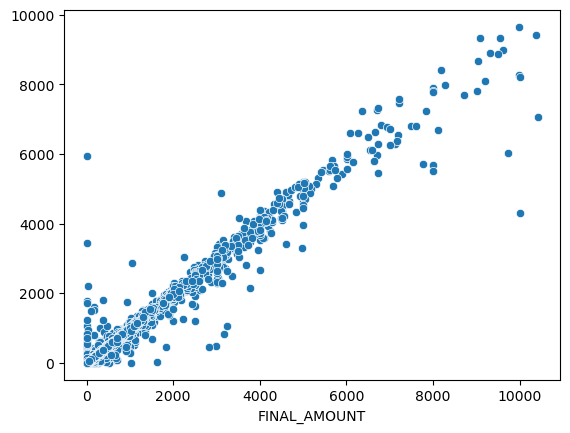

In [ ]:
sns.scatterplot(x=y_test, y=y_hat)